In [1]:
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from tqdm import tqdm

In [2]:
# Path to original and augmented image folders
input_path = 'BCCD_Dataset/BCCD/JPEGImages'
output_path = 'BCCD_Dataset/BCCD/AugmentedImages'

In [3]:
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [4]:
# Define augmentation pipeline
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomCrop(width=450, height=450, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=20, p=0.7),
    ToTensorV2()
])

In [5]:
# Apply augmentations to each image
for filename in tqdm(os.listdir(input_path)):
    if filename.endswith('.jpg'):
        image_path = os.path.join(input_path, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        augmented = augmentations(image=image)
        augmented_image = augmented['image'].permute(1, 2, 0).numpy()

        # Save the augmented image
        output_image_path = os.path.join(output_path, filename)
        cv2.imwrite(output_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

100%|██████████| 364/364 [00:08<00:00, 44.74it/s]


In [6]:
import torch
from ultralytics import YOLO
from PIL import Image
import numpy as np

In [8]:
!yolo settings

JSONDict("C:\Users\pmoha\AppData\Roaming\Ultralytics\settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "C:\\Users\\datasets",
  "weights_dir": "C:\\Users\\pmoha\\weights",
  "runs_dir": "C:\\Users\\pmoha\\runs",
  "uuid": "84819f1765575cc3070a89ea807447bffb0479d2ea45004964c480f92248cc81",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": false,
  "vscode_msg": true
}
ðŸ’¡ Learn more about Ultralytics Settings at https://docs.ultralytics.com/quickstart/#ultralytics-settings


Python Script to Convert XML to YOLO Format (for the given splits):

In [7]:
import os
import xml.etree.ElementTree as ET
import shutil

In [8]:
# Define paths
annotations_path = "C:/Users/pmoha/OneDrive/Desktop/Object Detection Web App/BCCD_Dataset/BCCD/Annotations/"
images_path = "C:/Users/pmoha/OneDrive/Desktop/Object Detection Web App/BCCD_Dataset/BCCD/JPEGImages/"
image_sets_path = "C:/Users/pmoha/OneDrive/Desktop/Object Detection Web App/BCCD_Dataset/BCCD/ImageSets/"


In [9]:
train_txt = r"C:\Users\pmoha\OneDrive\Desktop\Object Detection Web App\BCCD_Dataset\BCCD\ImageSets\Main\train.txt"
val_txt = r"C:\Users\pmoha\OneDrive\Desktop\Object Detection Web App\BCCD_Dataset\BCCD\ImageSets\Main\val.txt"

In [10]:
train_images_path = "C:/Users/pmoha/OneDrive/Desktop/Object Detection Web App/BCCD_Dataset/train_images/"
val_images_path = "C:/Users/pmoha/OneDrive/Desktop/Object Detection Web App/BCCD_Dataset/val_images/"
train_labels_path = "C:/Users/pmoha/OneDrive/Desktop/Object Detection Web App/BCCD_Dataset/train_labels/"
val_labels_path = "C:/Users/pmoha/OneDrive/Desktop/Object Detection Web App/BCCD_Dataset/val_labels/"

In [11]:
# Class names mapping
class_names = {"RBC": 0, "WBC": 1, "Platelets": 2}

In [12]:
# Ensure output directories exist
os.makedirs(train_images_path, exist_ok=True)
os.makedirs(val_images_path, exist_ok=True)
os.makedirs(train_labels_path, exist_ok=True)
os.makedirs(val_labels_path, exist_ok=True)

In [13]:
def convert_xml_to_yolo_format(xml_file, output_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Image dimensions (width, height)
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    with open(output_file, 'w') as f:
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            if class_name in class_names:
                class_id = class_names[class_name]
                bbox = obj.find('bndbox')
                x_min = int(bbox.find('xmin').text)
                y_min = int(bbox.find('ymin').text)
                x_max = int(bbox.find('xmax').text)
                y_max = int(bbox.find('ymax').text)

                # Convert bounding box to YOLO format
                x_center = (x_min + x_max) / (2 * width)
                y_center = (y_min + y_max) / (2 * height)
                w = (x_max - x_min) / width
                h = (y_max - y_min) / height

                # Write to file in YOLO format
                f.write(f"{class_id} {x_center} {y_center} {w} {h}\n")

In [14]:
def process_split(txt_file, images_dir, labels_dir):
    with open(txt_file, 'r') as f:
        filenames = f.read().splitlines()

    for filename in filenames:
        # Copy images to appropriate directory
        image_file = filename + '.jpg'
        shutil.copy(os.path.join(images_path, image_file), images_dir)

        # Convert XML to YOLO format and save labels
        xml_file = filename + '.xml'
        label_file = os.path.join(labels_dir, filename + '.txt')
        convert_xml_to_yolo_format(os.path.join(annotations_path, xml_file), label_file)

In [15]:
# Process train and validation splits
process_split(train_txt, train_images_path, train_labels_path)
process_split(val_txt, val_images_path, val_labels_path)
print("Dataset prepared and annotations converted.")

Dataset prepared and annotations converted.


In [16]:
# Define paths for test set
test_images_path = "C:/Users/pmoha/OneDrive/Desktop/Object Detection Web App/BCCD_Dataset/test_images/"
test_labels_path = "C:/Users/pmoha/OneDrive/Desktop/Object Detection Web App/BCCD_Dataset/test_labels/"

# Ensure output directories for test set exist
os.makedirs(test_images_path, exist_ok=True)
os.makedirs(test_labels_path, exist_ok=True)

# Add test.txt in ImageSets folder with filenames of the test images
test_txt = r"C:\Users\pmoha\OneDrive\Desktop\Object Detection Web App\BCCD_Dataset\BCCD\ImageSets\Main\test.txt"

In [17]:
# Process test split
process_split(test_txt, test_images_path, test_labels_path)

print("Dataset prepared and annotations converted, including test set.")

Dataset prepared and annotations converted, including test set.


In [41]:
# !python train.py --img 640 --batch 16 --epochs 50 --data C:/Users/pmoha/OneDrive/Desktop/Object Detection Web App/BCCD_dataset.yaml --weights yolov10.pt --device 0

In [18]:
model = YOLO('yolov10n.pt')  # Initialize with a YOLO configuration or pretrained model

In [21]:
# Train the model on the BCCD dataset
model.train(data='C:/Users/pmoha/OneDrive/Desktop/Object Detection Web App/BCCD_dataset.yaml', epochs=50, imgsz=640, batch=16)

Ultralytics 8.3.31  Python-3.9.20 torch-2.5.1 CPU (12th Gen Intel Core(TM) i5-1240P)
engine\trainer: task=detect, mode=train, model=yolov10n.pt, data=C:/Users/pmoha/OneDrive/Desktop/Object Detection Web App/BCCD_dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cro

train: Scanning C:\Users\pmoha\OneDrive\Desktop\Object Detection Web App\BCCD_Dataset\train_images... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<00:00, 520.12it/s]

train: New cache created: C:\Users\pmoha\OneDrive\Desktop\Object Detection Web App\BCCD_Dataset\train_images.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\pmoha\OneDrive\Desktop\Object Detection Web App\BCCD_Dataset\val_images... 87 images, 0 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<00:00, 559.38it/s]

val: New cache created: C:\Users\pmoha\OneDrive\Desktop\Object Detection Web App\BCCD_Dataset\val_images.cache


Plotting labels to C:\Users\pmoha\runs\detect\train5\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to C:\Users\pmoha\runs\detect\train5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      2.638      7.014      2.782        347        640: 100%|██████████| 13/13 [04:39<00:00, 21.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:35<00:00, 11.83s/it]

                   all         87       1138     0.0196      0.573      0.116     0.0696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      2.411       5.25      2.314        330        640: 100%|██████████| 13/13 [05:05<00:00, 23.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:43<00:00, 14.37s/it]

                   all         87       1138     0.0212       0.65      0.356      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      2.453      3.859      2.311        322        640: 100%|██████████| 13/13 [05:35<00:00, 25.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:39<00:00, 13.27s/it]

                   all         87       1138     0.0199      0.626      0.376      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      2.557      3.215      2.385        364        640: 100%|██████████| 13/13 [05:29<00:00, 25.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:47<00:00, 15.75s/it]


                   all         87       1138      0.876      0.125      0.454      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      2.447      2.982      2.377        277        640: 100%|██████████| 13/13 [05:44<00:00, 26.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.60s/it]

                   all         87       1138     0.0243      0.656      0.426      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      2.325      2.818      2.345        320        640: 100%|██████████| 13/13 [05:23<00:00, 24.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:35<00:00, 11.94s/it]

                   all         87       1138      0.813      0.376      0.468      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      2.296      2.584      2.319        379        640: 100%|██████████| 13/13 [04:37<00:00, 21.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:34<00:00, 11.56s/it]

                   all         87       1138      0.793      0.449      0.494      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G       2.31      2.536      2.347        298        640: 100%|██████████| 13/13 [04:41<00:00, 21.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:32<00:00, 10.95s/it]

                   all         87       1138      0.789      0.429      0.648      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      2.239      2.433      2.274        300        640: 100%|██████████| 13/13 [04:17<00:00, 19.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.35s/it]

                   all         87       1138      0.823      0.485       0.72      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      2.269      2.395      2.295        281        640: 100%|██████████| 13/13 [01:36<00:00,  7.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.50s/it]

                   all         87       1138      0.748      0.643      0.759      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      2.219      2.329      2.323        271        640: 100%|██████████| 13/13 [01:46<00:00,  8.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.01s/it]

                   all         87       1138       0.66      0.647      0.762      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      2.247      2.228      2.293        312        640: 100%|██████████| 13/13 [01:47<00:00,  8.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.10s/it]

                   all         87       1138      0.694      0.719      0.796      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      2.287       2.15      2.271        360        640: 100%|██████████| 13/13 [01:46<00:00,  8.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.66s/it]

                   all         87       1138      0.695      0.775      0.783      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      2.287      2.179       2.31        336        640: 100%|██████████| 13/13 [01:40<00:00,  7.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.59s/it]

                   all         87       1138      0.625      0.787      0.796      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      2.215      2.119      2.278        287        640: 100%|██████████| 13/13 [01:40<00:00,  7.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.42s/it]

                   all         87       1138      0.642      0.757      0.784      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      2.292        2.1      2.287        248        640: 100%|██████████| 13/13 [01:32<00:00,  7.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.29s/it]

                   all         87       1138      0.697      0.795      0.781      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      2.249      2.044      2.267        280        640: 100%|██████████| 13/13 [01:31<00:00,  7.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.21s/it]

                   all         87       1138      0.737      0.787      0.807      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      2.161      1.945      2.223        327        640: 100%|██████████| 13/13 [01:32<00:00,  7.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.30s/it]

                   all         87       1138      0.754      0.776       0.82      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      2.175      2.043      2.295        243        640: 100%|██████████| 13/13 [01:30<00:00,  6.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.18s/it]

                   all         87       1138      0.739      0.769      0.808      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      2.117      1.926       2.23        281        640: 100%|██████████| 13/13 [01:29<00:00,  6.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.22s/it]

                   all         87       1138      0.749      0.747      0.795      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      2.127      1.913      2.243        285        640: 100%|██████████| 13/13 [01:30<00:00,  6.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.40s/it]

                   all         87       1138      0.766      0.764      0.813      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      2.112      1.883      2.233        354        640: 100%|██████████| 13/13 [01:36<00:00,  7.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.37s/it]

                   all         87       1138      0.745      0.787       0.81      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      2.129      1.876      2.242        291        640: 100%|██████████| 13/13 [01:35<00:00,  7.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.36s/it]

                   all         87       1138       0.74      0.796      0.822      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      2.113      1.842      2.217        231        640: 100%|██████████| 13/13 [01:38<00:00,  7.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.64s/it]

                   all         87       1138      0.749      0.812      0.822       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G       2.13      1.852      2.233        353        640: 100%|██████████| 13/13 [01:45<00:00,  8.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.75s/it]

                   all         87       1138      0.753      0.801      0.821      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G       2.06      1.824      2.188        308        640: 100%|██████████| 13/13 [01:41<00:00,  7.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.31s/it]

                   all         87       1138      0.773      0.812      0.824      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      2.106      1.804      2.215        367        640: 100%|██████████| 13/13 [01:37<00:00,  7.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.71s/it]

                   all         87       1138      0.741      0.808      0.818      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      2.071      1.726      2.192        326        640: 100%|██████████| 13/13 [01:54<00:00,  8.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.73s/it]

                   all         87       1138      0.708      0.856      0.842      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      2.042       1.73       2.17        290        640: 100%|██████████| 13/13 [01:53<00:00,  8.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.79s/it]

                   all         87       1138      0.768      0.845      0.846       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G       2.05      1.731        2.2        326        640: 100%|██████████| 13/13 [01:53<00:00,  8.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.62s/it]

                   all         87       1138      0.752       0.85      0.836      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      2.044      1.678      2.195        325        640: 100%|██████████| 13/13 [01:52<00:00,  8.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.88s/it]

                   all         87       1138      0.727      0.862      0.853      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      2.054      1.664      2.192        272        640: 100%|██████████| 13/13 [01:51<00:00,  8.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.84s/it]

                   all         87       1138      0.775      0.809      0.845       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      2.014      1.656      2.178        326        640: 100%|██████████| 13/13 [01:54<00:00,  8.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.88s/it]

                   all         87       1138      0.784      0.816      0.839      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G       1.98      1.653      2.152        324        640: 100%|██████████| 13/13 [01:52<00:00,  8.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.74s/it]

                   all         87       1138      0.745      0.837      0.843      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.986      1.607       2.16        346        640: 100%|██████████| 13/13 [01:54<00:00,  8.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.76s/it]

                   all         87       1138      0.729      0.864      0.835      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      1.973      1.577      2.142        408        640: 100%|██████████| 13/13 [01:52<00:00,  8.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.99s/it]

                   all         87       1138      0.782      0.776      0.831      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.973      1.579      2.164        304        640: 100%|██████████| 13/13 [01:49<00:00,  8.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.81s/it]

                   all         87       1138      0.758      0.835      0.834      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.942       1.53      2.145        293        640: 100%|██████████| 13/13 [01:51<00:00,  8.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.71s/it]

                   all         87       1138      0.757      0.847      0.832      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.956      1.565      2.168        298        640: 100%|██████████| 13/13 [01:50<00:00,  8.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.87s/it]

                   all         87       1138      0.757       0.84      0.836      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.905      1.498      2.125        285        640: 100%|██████████| 13/13 [01:55<00:00,  8.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.74s/it]

                   all         87       1138      0.776      0.821      0.846      0.593


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.944      1.784      2.177        157        640: 100%|██████████| 13/13 [01:49<00:00,  8.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.90s/it]

                   all         87       1138      0.755      0.814      0.837      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      1.873      1.571      2.131        163        640: 100%|██████████| 13/13 [01:46<00:00,  8.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.88s/it]

                   all         87       1138       0.77      0.844      0.841      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      1.876      1.523      2.118        182        640: 100%|██████████| 13/13 [01:49<00:00,  8.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.77s/it]

                   all         87       1138      0.735      0.885      0.839      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.841        1.5      2.154        171        640: 100%|██████████| 13/13 [01:46<00:00,  8.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.81s/it]

                   all         87       1138      0.738      0.845      0.834       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G       1.82       1.41      2.096        174        640: 100%|██████████| 13/13 [01:48<00:00,  8.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.83s/it]

                   all         87       1138       0.77      0.831      0.845      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G      1.835      1.448      2.157        166        640: 100%|██████████| 13/13 [01:46<00:00,  8.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.87s/it]

                   all         87       1138      0.777      0.842      0.858        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      1.816      1.392      2.084        182        640: 100%|██████████| 13/13 [01:49<00:00,  8.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.96s/it]

                   all         87       1138      0.778      0.838      0.861      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G      1.834      1.426      2.148        181        640: 100%|██████████| 13/13 [01:46<00:00,  8.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.83s/it]

                   all         87       1138      0.789      0.848      0.861      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      1.783      1.361      2.085        166        640: 100%|██████████| 13/13 [01:47<00:00,  8.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.85s/it]

                   all         87       1138      0.782      0.866      0.861      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G      1.795      1.367      2.109        201        640: 100%|██████████| 13/13 [01:49<00:00,  8.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.80s/it]

                   all         87       1138      0.773      0.862      0.861      0.599



50 epochs completed in 2.182 hours.
Optimizer stripped from C:\Users\pmoha\runs\detect\train5\weights\last.pt, 5.7MB
Optimizer stripped from C:\Users\pmoha\runs\detect\train5\weights\best.pt, 5.7MB

Validating C:\Users\pmoha\runs\detect\train5\weights\best.pt...
Ultralytics 8.3.31  Python-3.9.20 torch-2.5.1 CPU (12th Gen Intel Core(TM) i5-1240P)
YOLOv10n summary (fused): 285 layers, 2,695,586 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.78s/it]


                   all         87       1138      0.788      0.849      0.861      0.601
                   RBC         83        968      0.735      0.788       0.83      0.593
                   WBC         86         87      0.942          1      0.992      0.812
             Platelets         45         83      0.688      0.759      0.761      0.399
Speed: 1.0ms preprocess, 82.7ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to C:\Users\pmoha\runs\detect\train5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001DB9296DC70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          

In [23]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

# Example augmentation pipeline
transform = A.Compose([
    A.Rotate(limit=40, p=0.7),
    A.RandomCrop(width=256, height=256, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(p=0.2),
    ToTensorV2()
])

# Apply to an image
image = cv2.imread("C:/Users/pmoha/OneDrive/Desktop/Object Detection Web App/BCCD_Dataset/test_images/BloodImage_00007.jpg")
augmented_image = transform(image=image)['image']


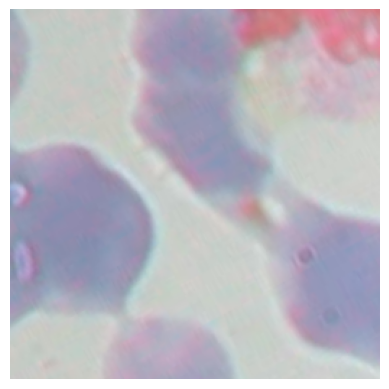

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

# Convert tensor back to numpy for displaying
augmented_image_numpy = augmented_image.permute(1, 2, 0).numpy()

# Show image
plt.imshow(augmented_image_numpy)
plt.axis('off')
plt.show()

In [46]:
from ultralytics import YOLO
import cv2

# Load YOLO model
def load_yolo_model(weights_path):
    model = YOLO(weights_path)  # Load the trained model weights
    return model

# Perform inference on an image
def perform_inference(model, image_path):
    image = cv2.imread(image_path)  # Read the image using OpenCV
    results = model(image)  # Run inference on the image
    
    # Check if results is a list (YOLO might return a list of results)
    if isinstance(results, list):
        # Iterate through each result in the list
        for result in results:
            result.show()  # Show annotated image
    else:
        # If results is not a list, just render and display
        results.show()  # Display the annotated image
    
    return results

# Example usage
weights_path = r'C:/Users/pmoha/runs/detect/train5/weights/best.pt'  # Path to YOLOv5 trained weights
model = load_yolo_model(weights_path=weights_path)

image_path = r"C:/Users/pmoha/OneDrive/Desktop/Object Detection Web App/BCCD_Dataset/BCCD/JPEGImages/BloodImage_00000.jpg"  # Path to the image
result = perform_inference(model, image_path)



0: 480x640 21 RBCs, 1 WBC, 257.7ms
Speed: 7.3ms preprocess, 257.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)
